### Convert a file from Label Studio format to a format suitable for classification tasks

You can export the data from Label Studio in a JSON format that is not suitable for classification tasks. The following code converts the JSON file to a format which is a list of dictionaries, where each dictionary has the following keys: title, abstract.


In [3]:
input_file = "./example_ls_exports.json"
# Save the extracted data to a new JSON file
output_file_path = "./example.json"
text2knowledge_dir = "../examples/text2knowledge"

In [5]:
import json

data = json.load(open(input_file))
# Extract the title and abstract
extracted_data = [
    {
        "title": item["data"].get("title", ""),
        "abstract": item["data"].get("abstract", ""),
        "pmid": item["data"].get("pmid", ""),
    }
    for item in data
]

with open(output_file_path, "w") as output_file:
    json.dump(extracted_data, output_file, indent=4)


for item in extracted_data:
    text = f"Title: {item['title']}\n\nAbstract: {item['abstract']}"
    pmid = item["pmid"]

    if not pmid:
        continue

    with open(f"{text2knowledge_dir}/{pmid}.txt", "w") as output_file:
        output_file.write(text)

### Pull Models

In [79]:
models = ["llama3.1:70b", "mistral:7b", "mixtral:8x7b", "mixtral:8x22b"]

# !bash ../pull_models.sh llama3.1:70b mistral:7b mixtral:8x7b mixtral:8x22b
model_args = " ".join(models)
!bash ../pull_models.sh $model_args

llama3.1:70b mistral:7b mixtral:8x7b mixtral:8x22b
Models to download: llama3.1:70b mistral:7b mixtral:8x7b mixtral:8x22b
Models to download: llama3.1:70b mistral:7b mixtral:8x7b mixtral:8x22b
Executing: ollama pull llama3.1:70b
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling aa81b541aae6... 100% ▕████████████████▏  39 GB                         
pulling 8cf247399e57... 100% ▕████████████████▏ 1.7 KB                         
pulling f1cd752815fc... 100% ▕████████████████▏  12 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 3c1c2d3df5b3... 100% ▕████████████████▏  486 B                         
verifying sha256 digest 
writing manifest 
removing any unused layers 
success 
Successfully downloaded llama3.1:70b
Executing: ollama pull mistral:7b
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1

### Run the Classification Task

In [ ]:
input_file = "./example.json"
models = ["llama3.1:70b", "mistral:7b", "mixtral:8x7b", "mixtral:8x22b"]

In [80]:
output_files = [f"./results/{model.replace('.', '_').replace(':', '_')}.json" for model in models]

# Process each model
for output_file, model in zip(output_files, models):
    # Ensure the command is formatted correctly
    command = f"python text2knowledge.py classify-article --input-file {input_file} --output-file {output_file} -m {model}"
    os.system(command)

['./results/llama3_1_70b.json',
 './results/mistral_7b.json',
 './results/mixtral_8x7b.json',
 './results/mixtral_8x22b.json']

### Analyze and evaluate the results of the classification task

#### List of Classification Results

In [40]:
# models = ["llama3.1:70b", "mistral:7b", "mixtral:8x7b", "mixtral:8x22b"]
# files = [
#     f"./results/{model.replace('.', '_').replace(':', '_')}.json" for model in models
# ]

files = [
    "./results/llama3_1_70b.json",
    "./results/mistral_7b.json",
    "./results/mixtral_8x7b.json",
    "./results/mixtral_8x22b.json"
]

#### Analyzing Model Data for Category and Error Ratios

In [41]:
import pandas as pd
import json
import os
from typing import List, Dict

def read_json(filepath: str) -> List[Dict]:
    with open(filepath, "r") as file:
        data = json.load(file)
    return data

def extract_model_names(filepath: str) -> str:
    filename = os.path.basename(filepath)
    # llama3_1_70b.json -> llama3.1:70b, mistral_7b.json -> mistral:7b
    model_name = ".".join(filename.split("_")[0:-1])
    version = filename.split("_")[-1].split(".")[0]
    return f"{model_name}:{version}"

def extract_data(model_data, model_name):
    data = []
    for entry in model_data:
        title = entry.get("title", "Unknown")
        category = entry.get("category", "Unknown")
        if "error" in entry:
            category = "Error"
        data.append([title, category])
    return pd.DataFrame(data, columns=["Title", model_name])

# 预设的分类范围
valid_categories = [
    "Molecular Mechanism Study",
    "Review",
    "Clinical Trial",
    "Epidemiological Study",
    "Retrospective Study",
    "Clinical Test Index Study",
    "Case Report",
    "Meta-Analysis",
    "Unknown",
]

# 统计超出预设分类范围的比例
def calculate_out_of_range_ratio(df, valid_categories, model_name):
    total = len(df)
    out_of_range = df[~df[model_name].isin(valid_categories)]
    ratio = len(out_of_range) / total
    return ratio


# 统计符合分类范围的比例
def calculate_in_range_ratio(df, valid_categories, model_name):
    total = len(df)
    in_range = df[df[model_name].isin(valid_categories)]
    ratio = len(in_range) / total
    return ratio


# 统计出现Error字段的比例
def calculate_error_ratio(df, model_name):
    total = len(df)
    errors = df[df[model_name] == "Error"]
    ratio = len(errors) / total
    return ratio

In [42]:
merged_df = pd.DataFrame()
loaded_data = {}
for file in files:
    model_data = read_json(file)
    model_name = extract_model_names(file)
    model_df = extract_data(model_data, model_name)
    if merged_df.empty:
        merged_df = model_df
    else:
        merged_df = pd.merge(merged_df, model_df, on="Title", how="outer")

    loaded_data[model_name] = model_data

all_model_names = merged_df.columns[1:]

# 统计超出预设分类范围的比例, 反映模型的指令遵循能力
out_of_range_ratios = {
    model_name: calculate_out_of_range_ratio(merged_df, valid_categories, model_name)
    for model_name in all_model_names
}

# 统计符合分类范围的比例
in_range_ratios = {
    model_name: calculate_in_range_ratio(merged_df, valid_categories, model_name)
    for model_name in all_model_names
}

# 统计出现Error字段的比例
error_ratios = {
    model_name: calculate_error_ratio(merged_df, model_name) for model_name in all_model_names
}

# 输出统计结果
results = pd.DataFrame()
results["model"] = all_model_names
results["out_of_range_ratio"] = [out_of_range_ratios[model_name] for model_name in all_model_names]
results["in_range_ratio"] = [in_range_ratios[model_name] for model_name in all_model_names]
results["error_ratio"] = [error_ratios[model_name] for model_name in all_model_names]

results

,model,out_of_range_ratio,in_range_ratio,error_ratio
0,llama3.1:70b,0.031579,0.968421,0.010526
1,mistral:7b,0.040789,0.959211,0.000000
2,mixtral:8x7b,0.039474,0.960526,0.013158
3,mixtral:8x22b,0.011842,0.988158,0.000000


#### Finding Specific Items in Loaded Data

In [63]:
def find_item(model_name, title, loaded_data):
    for item in loaded_data[model_name]:
        if item.get("title") == title:
            return item

    return None


def find_error_items(model_name: str, loaded_data) -> List[Dict]:
    data = loaded_data[model_name]
    error_items = [item for item in data if "error" in item]

    return error_items


def find_out_of_range_items(model_name: str, loaded_data) -> List[Dict]:
    data = loaded_data[model_name]
    out_of_range_items = [
        item for item in data if item.get("category") not in valid_categories
    ]

    return out_of_range_items

In [64]:
# 查找错误的数据
find_error_items("llama3.1:70b", loaded_data)

[{'error': "\n\nERROR ### Here is the buggy response: I'm ready to analyze the text. Please go ahead and provide the paper title and abstract enclosed in triple backticks (```), and I'll give my judgment in JSON format, including 'category' and 'reason' fields.",
  'category': 'Unknown',
  'title': '',
  'abstract': '/data/upload/18/cda8eabf-20231009-YuchenYe-3.yaml'},
 {'error': "\n\nERROR ### Here is the buggy response: I'm ready to analyze the content. However, I don't see any text provided within the triple backticks (```). Could you please provide the title and abstract of the paper, enclosed in triple backticks, so I can assist with categorizing it according to the guidelines?",
  'category': 'Unknown',
  'title': '',
  'abstract': '/data/upload/18/dbfdd323-20231009-YuchenYe-3.yaml'}]

In [65]:
# 查找超出范围的数据
print("Number of out of range items:", len(find_out_of_range_items("llama3.1:70b", loaded_data)))
find_out_of_range_items("llama3.1:70b", loaded_data)

Number of out of range items: 16


[{'category': 'Case-Control Comparison',
  'title': 'Orthostatic Intolerance in Long-Haul COVID after SARS-CoV-2: A Case-Control Comparison with Post-EBV and Insidious-Onset Myalgic Encephalomyelitis/Chronic Fatigue Syndrome Patients.',
  'abstract': 'BACKGROUND: As complaints of long-haul COVID patients are similar to those of ME/CFS patients and as orthostatic intolerance (OI) plays an important role in the COVID infection symptomatology, we compared 14 long-haul COVID patients with 14 ME/CFS patients with a post-viral Ebstein-Barr (EBV) onset and 14 ME/CFS patients with an insidious onset of the disease. METHODS: In all patients, OI analysis by history taking and OI assessed during a tilt test, as well as cerebral blood flow measurements by extracranial Doppler, and cardiac index measurements by suprasternal Doppler during the tilt test were obtained in all patients. RESULTS: Except for disease duration no differences were found in clinical characteristics. The prevalence of POTS wa

#### Venn Diagram of Classification Results

In [56]:
import matplotlib.pyplot as plt
from venn import venn
from collections import defaultdict

def plot_venn(models, df):
    # 初始化集合字典
    category_sets = {model: set() for model in models}

    # 计算每个模型间分类一致的数量
    for _, row in df.iterrows():
        for model in models:
            category_sets[model].add((row["Title"], row[model]))

    # 创建venn图所需的数据
    venn_data = {model: category_sets[model] for model in models}

    # 绘制venn图
    plt.figure(figsize=(10, 7))
    venn(venn_data)
    plt.title("Venn Diagram of Model Category Agreements and Disagreements")
    plt.show()

<Figure size 1000x700 with 0 Axes>

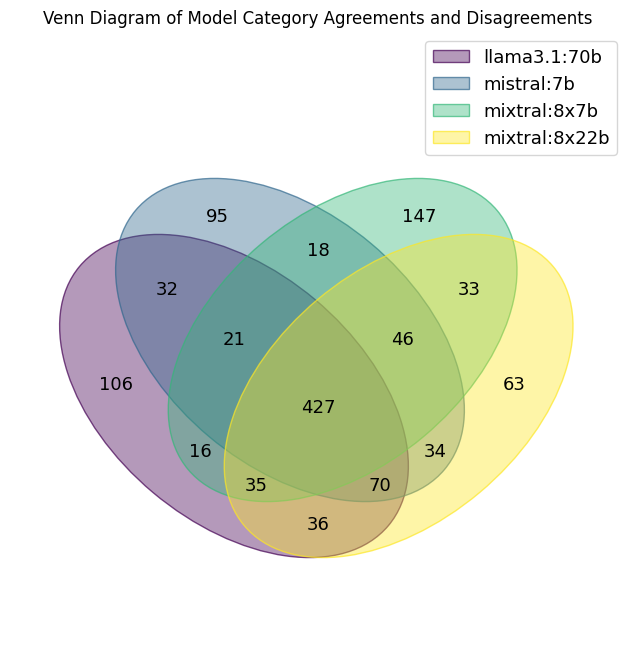

In [57]:
# 假设merged_df是您合并后的数据框
models = merged_df.columns[1:]
plot_venn(models, merged_df)

#### Calculating Agreement Counts Across Multiple Models

In [61]:
# 计算模型间的一致数量
def calculate_agreement_counts(df, models):
    agreement_matrix = pd.DataFrame(index=models, columns=models)

    for model1 in models:
        for model2 in models:
            if model1 == model2:
                agreement_matrix.loc[model1, model2] = len(df[df[model1] == df[model2]])
            else:
                agreement_count = len(df[df[model1] == df[model2]])
                agreement_matrix.loc[model1, model2] = agreement_count

    return agreement_matrix

In [62]:
# 假设merged_df是你合并后的数据框
models = merged_df.columns[1:]
summary_df = calculate_agreement_counts(merged_df, models)
summary_df

,llama3.1:70b,mistral:7b,mixtral:8x7b,mixtral:8x22b
llama3.1:70b,760,560,513,578
mistral:7b,560,760,519,587
mixtral:8x7b,513,519,760,548
mixtral:8x22b,578,587,548,760


#### Calculating Agreement Ratios Across Multiple Models

In [48]:
import pandas as pd

# 计算模型间的一致性比例
def calculate_agreement_ratios(df, models):
    agreement_matrix = pd.DataFrame(index=models, columns=models)

    for model1 in models:
        for model2 in models:
            if model1 == model2:
                agreement_matrix.loc[model1, model2] = 1.0
            else:
                total_count = len(df)
                agreement_count = len(df[df[model1] == df[model2]])
                agreement_ratio = agreement_count / total_count
                agreement_matrix.loc[model1, model2] = agreement_ratio

    return agreement_matrix


# 示例使用
models = merged_df.columns[1:]
agreement_matrix = calculate_agreement_ratios(merged_df, models)

agreement_matrix

,llama3.1:70b,mistral:7b,mixtral:8x7b,mixtral:8x22b
llama3.1:70b,1.0,0.736842,0.675,0.760526
mistral:7b,0.736842,1.0,0.682895,0.772368
mixtral:8x7b,0.675,0.682895,1.0,0.721053
mixtral:8x22b,0.760526,0.772368,0.721053,1.0
